# Sample notebook for rotating and scaling an individual eddy

In [1]:
import intake

import xarray as xr
xr.set_options(keep_attrs=True)

import eddytransform as et
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs

## Parameter settings

In [3]:
# Specify EERIE data
gridtype = 'regular' # irregular # is the data on a 'regular' lat on grid or other?
res = '0.25deg' # 0.1deg
infilename = 'data/data_0.25deg.nc'

# gridtype = 'regular' # irregular # is the data on a 'regular' lat on grid or other?
# res = '0.1deg'
# infilename = 'data/data_0.1deg.nc'

# gridtype = 'irregular' # is the data on a 'regular' lat on grid or other?
# res = 'native'
# infilename = 'data/data_native.nc'

# time/lon/lat coordinates of imagined eddy
TIME = '2021-01-11 12:00:00'
EDDY_LON = -71
EDDY_LAT = 39.5

varname = 'avg_sst'

In [4]:
# Settings for eddy transformation - decent default values
DOMAIN_HALF_WIDTH_IN_DEGREES = 20 # domain half width
AVG_WIND_EDDY_RADIUSES = 3 # Number of eddy radiuses used for calculating direction of large-scale winds. 
RESAMPLE_EDDY_RADIUSES = 3 # Number of eddy radiuses to sample in transformed composite coordinates.
RESAMPLE_DENSITY = 30 # Number of data points per eddy radius in transformed composite coordinates.
UPARAM = "avg_10u" # zonal surface wind velocity, for eddy rotation
VPARAM = "avg_10v" # meridional surface wind velocity, for eddy rotation

## Read & process data 

In [5]:
# Read & process data 
print('Open datasets')
ds = xr.open_dataset(
    infilename
)

Open datasets


In [19]:
ds

<xarray.Dataset> Size: 50MB
Dimensions:  (time: 1, lat: 721, lon: 1440)
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * time     (time) datetime64[ns] 8B 2021-01-11T12:00:00
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    avg_sst  (time, lat, lon) float64 8MB ...
    mean2t   (time, lat, lon) float64 8MB ...
    mslhf    (time, lat, lon) float64 8MB ...
    tprate   (time, lat, lon) float64 8MB ...
    avg_10u  (time, lat, lon) float64 8MB ...
    avg_10v  (time, lat, lon) float64 8MB ...
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

lontype identified as 360
assume regular grid
lontype identified as 360
assume regular grid


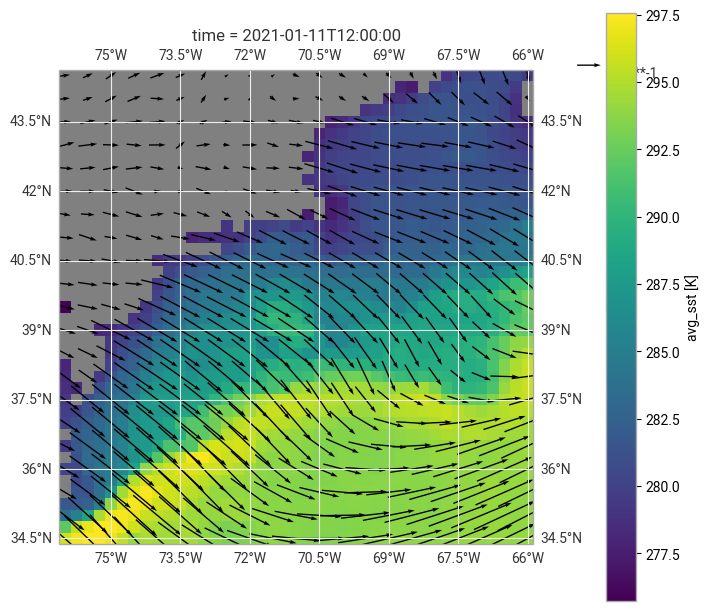

In [21]:
fig, ax = plt.subplots(constrained_layout=True,subplot_kw=dict(projection=ccrs.PlateCarree()))
cf = et.sel_region(
    ds[varname].sel(
        time=TIME
    ),
    # 360+EDDY_LON,EDDY_LAT,5
    EDDY_LON,EDDY_LAT,5
).plot(transform=ccrs.PlateCarree())

quiver = et.sel_region(
    ds[[UPARAM,VPARAM]].sel(
        time=TIME
    ),
    # 360+EDDY_LON,EDDY_LAT,5
    EDDY_LON,EDDY_LAT,5
).isel(lon=slice(None,None, 2),lat=slice(None,None, 2)).plot.quiver(
        x='lon', y='lat', u='avg_10u', v='avg_10v', scale=100
    ) 

ax.set_facecolor('grey')
ax.gridlines(draw_labels=True)

## Transform eddy

In [7]:
eddy_centered = et.transform_eddy(
    ds,
    COMPOSITE_PARAM = varname,
    TIME_DX = TIME,
    EDDY_LON = EDDY_LON,
    EDDY_LAT = EDDY_LAT,
    DOMAIN_HALF_WIDTH_IN_DEGREES = DOMAIN_HALF_WIDTH_IN_DEGREES,
    EDDY_RADIUS = 100,
    AVG_WIND_EDDY_RADIUSES = AVG_WIND_EDDY_RADIUSES,
    RESAMPLE_EDDY_RADIUSES = RESAMPLE_EDDY_RADIUSES,
    RESAMPLE_DENSITY = RESAMPLE_DENSITY,
    UPARAM = UPARAM,
    VPARAM = VPARAM,
)

['avg_sst', '2021-01-11 12:00:00', -71, 39.5, 20, 100, 3, 3, 30, 'avg_10u', 'avg_10v']
lontype identified as 360
adjust EDDY_LON to fit lontype == '360'
EDDY_LON = 289.0
lontype identified as 360
assume regular grid
Assume regular grid
wind direction, assuming regular grid


## Rotate near-surface winds

In [8]:
eddy_centered_winds = et.transform_winds(
    ds[[UPARAM,VPARAM]],
    TIME_DX = TIME,
    EDDY_LON = 360+EDDY_LON,
    EDDY_LAT = EDDY_LAT,
    DOMAIN_HALF_WIDTH_IN_DEGREES = DOMAIN_HALF_WIDTH_IN_DEGREES,
    EDDY_RADIUS = 100,
    AVG_WIND_EDDY_RADIUSES = AVG_WIND_EDDY_RADIUSES,
    RESAMPLE_EDDY_RADIUSES = RESAMPLE_EDDY_RADIUSES,
    RESAMPLE_DENSITY = RESAMPLE_DENSITY,
    UPARAM = UPARAM,
    VPARAM = VPARAM
)

['rotate u/v', '2021-01-11 12:00:00', 289, 39.5, 20, 100, 3, 3, 30, 'avg_10u', 'avg_10v']
lontype identified as 360
lontype identified as 360
assume regular grid
Assume regular grid
wind direction, assuming regular grid
Wind angle: -0.64 rad, -36.72 deg


In [9]:
eddy_centered = xr.merge(
    [
        eddy_centered,
        eddy_centered_winds
    ]
)

Text(1.0, 1.0, '2021-01-11 12:00:00')

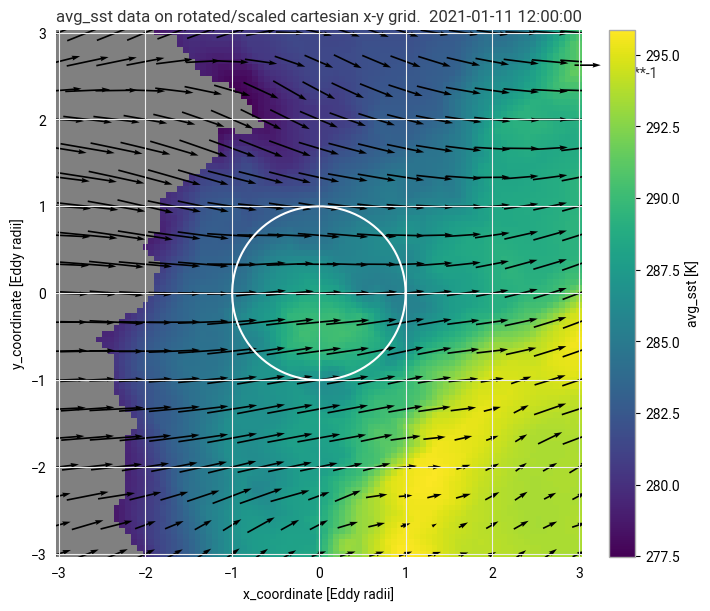

In [10]:
fig, ax = plt.subplots(constrained_layout=True)#,subplot_kw=dict(projection=ccrs.PlateCarree()))
eddy_centered['avg_sst'].plot(ax=ax)#cmap=cmo.thermal)

theta = np.linspace(0,2*np.pi,100)

plt.plot(
    np.cos(theta),
    np.sin(theta),
    'w'
)

eddy_centered.isel(
    x=slice(None,None, 5),y=slice(None,None, 5)
).plot.quiver(
    x='x',y='y',u='avg_10u',v='avg_10v',scale=100,
    ax=ax
)

ax.set_facecolor('grey')
ax.grid(True)

ax.set_title(f"{varname} data on rotated/scaled cartesian x-y grid.",loc='left')
ax.set_title(TIME,loc='right')


In [11]:
print('DONE')

DONE
